In [1]:
from jax import numpy as jnp
from matplotlib import pyplot as plt
import numpy as np

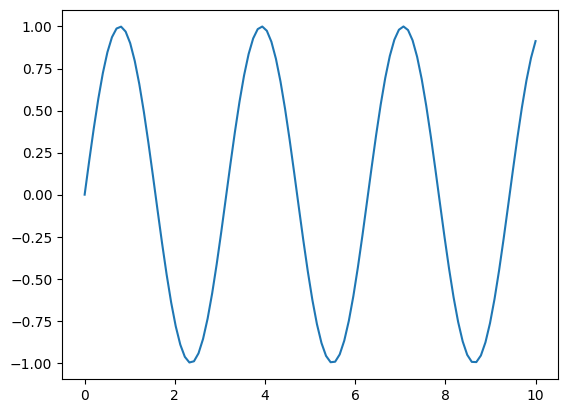

In [2]:
x = jnp.linspace(0, 10, 100)
y = 2 * jnp.sin(x) * jnp.cos(x)
plt.plot(x, y)

In [3]:
x = jnp.arange(10)
# x[4] = 10
y = x.at[4].set(10)
print(y)

[ 0  1  2  3 10  5  6  7  8  9]


In [4]:
from icecream import ic

x = jnp.arange(10).reshape(2, 5)
ic(x)

ic| x: Array([[0, 1, 2, 3, 4],
              [5, 6, 7, 8, 9]], dtype=int32)


Array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]], dtype=int32)

In [5]:
y = x.at[0, 2].set(100)
ic(y)
ic(x)

ic| y: Array([[  0,   1, 100,   3,   4],
              [  5,   6,   7,   8,   9]], dtype=int32)
ic| x: Array([[0, 1, 2, 3, 4],
              [5, 6, 7, 8, 9]], dtype=int32)


Array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]], dtype=int32)

In [6]:
from jax import random

key = random.key(0)
random.normal(key, (100, 100), dtype=jnp.float32)

Array([[ 1.3969241 ,  0.25045034, -2.1396856 , ...,  0.3145455 ,
        -1.4147886 , -0.9089208 ],
       [-0.7179685 , -0.55156016,  0.5488421 , ...,  1.0389215 ,
         0.6316356 ,  1.2083954 ],
       [ 0.1089396 ,  0.41924244,  0.61395687, ..., -0.25856677,
         2.026924  , -0.840388  ],
       ...,
       [-1.7753865 ,  0.47193787, -1.0666512 , ..., -0.05554172,
         1.7904825 , -0.38509572],
       [ 1.1479    , -0.8108315 , -0.14811768, ...,  0.29534367,
         0.20607775, -0.40122998],
       [-0.8252757 ,  0.60466516,  2.5560381 , ...,  0.07566901,
         1.3775586 ,  0.7038264 ]], dtype=float32)

In [7]:
from jax import device_put

size = 3000

# Data is automatically pushed to the AI accelerator! (DeviceArray structure)
# No more need for ".to(device)" (PyTorch syntax)
x_jnp = random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)  # some diff in API exists!

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()  # 1) on GPU - fast
%timeit np.dot(x_np, x_np.T)  # 2) on CPU - slow (NumPy only works with CPUs)
%timeit jnp.dot(x_np, x_np.T).block_until_ready()  # 3) on GPU with transfer overhead

x_np_device = device_put(x_np)  # push NumPy explicitly to GPU
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()  # same as 1)

# Note1: I'm using GPU as a synonym for AI accelerator. 
# In reality, especially in Colab, this can also be a TPU, etc.

# Note2: block_until_ready() -> asynchronous dispatch

4.98 ms ± 56 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
100 ms ± 225 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.5 ms ± 19.2 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.96 ms ± 20.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
# Simple helper visualization function
def visualize_fn(fn, l=-10, r=10, n=500):
    x = jnp.linspace(l, r, num=n)
    y = fn(x).block_until_ready()
    plt.plot(x, y)
    plt.show()

# JAX Transformers

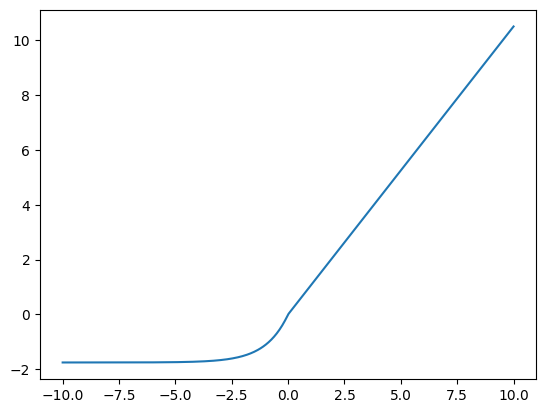

In [9]:
from jax import jit


def selu(x, alpha=1.67, lamb=1.05):
    return lamb * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)


selu_jit = jit(selu)
visualize_fn(selu_jit)

In [10]:
data = random.normal(key, (1_000_000,))
data.min(), data.max()

(Array(-4.75679, dtype=float32), Array(4.7694006, dtype=float32))

In [11]:
print('Non-jit version:')
%timeit selu(data).block_until_ready()
print('Jit version:')
%timeit selu_jit(data).block_until_ready()

Non-jit version:
736 μs ± 46.3 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Jit version:
71.2 μs ± 1.69 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# `grad()` 101 Lecture
Differentiable Programming with JAX

In [12]:
from jax import grad


def sum_logistic(x):
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))


x = jnp.arange(3.0)
ic(x)

loss = sum_logistic
grad_loss = grad(loss)
ic(grad_loss(x))

ic| x: Array([0., 1., 2.], dtype=float32)


ic| grad_loss(x): Array([0.25      , 0.19661194, 0.10499357], dtype=float32)


Array([0.25      , 0.19661194, 0.10499357], dtype=float32)

In [13]:
# Numeric diff (to double check that autodiff works correctly)
def finite_differences(f, x):
    eps = 1e-3
    # f(0+e, 1, 2) - f(0-e, 1, 2) / 2e
    return jnp.array(
        [
            (f(x + eps * v) - f(x - eps * v)) / (2 * eps)  # derivative definition
            for v in jnp.eye(len(x))
        ]
    )


ic(finite_differences(loss, x))

ic| finite_differences(loss, x): Array([0.24998187, 0.1965761 , 0.10502338], dtype=float32)


Array([0.24998187, 0.1965761 , 0.10502338], dtype=float32)

In [37]:
x = 1.0
y = 1.0

f = lambda x, y: x**2 + x + 4 + y**2  # simple 2nd order polynomial fn
# visualize_fn(f, l=-1, r=2, n=100)

dfdx = grad(f)  # 2*x + 1
d2fdx = grad(dfdx)  # 2
d3fdx = grad(d2fdx)  # 0

# x = jnp.array(1.0)

ic(f(x, y))
ic(dfdx(x, y))
ic(d2fdx(x, y))
ic(d3fdx(x, y))

ic| f(x, y): 7.0
ic| dfdx(x, y): Array(3., dtype=float32, weak_type=True)
ic| d2fdx(x, y): Array(2., dtype=float32, weak_type=True)
ic| d3fdx(x, y): Array(0., dtype=float32, weak_type=True)


Array(0., dtype=float32, weak_type=True)

# vmap() 101

In [38]:
W = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))  # simulated batch


def apply_matrix(x):
    return jnp.dot(W, x)

In [39]:
def naively_batched_apply_matrix(x):
    return jnp.stack([apply_matrix(xi) for xi in x])


print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
1.96 ms ± 6.49 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)  # (10, 100) * (100, 150) -> (10, 150)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
86.5 μs ± 2.38 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [41]:
from jax import vmap

@jit  # Note: we can arbitrarily compose JAX transforms! Here jit + vmap.
def vmap_batched_apply_matrix(batched_x):
    return vmap(apply_matrix)(batched_x)

# Task: modify apply_matrix to have 2 inputs and use in_axes arg

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
85 μs ± 1.17 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [44]:
from jax import lax

# Example 1: lax is stricter
print(jnp.add(1, 1.0))  # jax.numpy API implicitly promotes mixed types
# print(lax.add(1, 1.0))  # jax.lax API requires explicit type promotion
print(lax.add(1, 1))

2.0
2
